In [1]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from deep_macrofin import PDEModel
from deep_macrofin import ActivationType, Comparator, OptimizerType, set_seeds, SamplingMethod
from torch.func import hessian, jacrev, vmap

In [3]:
params = {
    "gamma": 0.5,
    "rho": 0.05,
    "r": 0.04,
    "y": 0.001,
}
set_seeds(0)
ode1 = PDEModel("bha", config={"num_epochs": 50000, "optimizer_type": OptimizerType.Adam, "sampling_method": SamplingMethod.FixedGrid})
ode1.set_state(["a"], {"a": [0.01, 0.99]})
ode1.add_params(params)
ode1.add_endog("V", config={"hidden_units": [30] * 4, "activation_type": ActivationType.SiLU})
ode1.add_endog_condition("V", 
                              "V(SV)", 
                              {"SV": torch.zeros((1, 1))},
                              Comparator.EQ,
                              "y**(1-gamma)/((1-gamma)*rho)", params,
                              label="v1", weight=1.0)
ode1.add_endog_condition("V", 
                              "V(SV)", 
                              {"SV": torch.ones((1, 1))},
                              Comparator.EQ,
                              "(1/gamma * (rho-r*(1-gamma)))**(-gamma)/(1-gamma)", params,
                              label="v2", weight=1.0)
ode1.add_equation("c=(V_a)**(-1/gamma)")
# ode1.add_constraint("V_a", Comparator.GEQ, "0")
# ode1.add_constraint("V_aa", Comparator.LEQ, "0")
ode1.add_hjb_equation("c**(1-gamma)/(1-gamma) + V_a * (r*a+y-c)-rho*V", weight=1)
print(ode1)
if not os.path.exists("./models/bha/model_2d.pt"):
    ode1.train_model("./models/bha", "model_2d.pt", True)
    ode1.load_model(torch.load("./models/bha/model_2d.pt", weights_only=False))
    ode1.eval_model(True)
else:
    ode1.load_model(torch.load("./models/bha/model_2d.pt", weights_only=False))
    ode1.eval_model(True)

==============================Summary of Model bha==============================
Config: {
 "batch_size": 100,
 "num_epochs": 50000,
 "lr": 0.001,
 "loss_log_interval": 100,
 "optimizer_type": "Adam",
 "sampling_method": "FixedGrid",
 "refinement_rounds": 5,
 "loss_balancing": false,
 "bernoulli_prob": 0.9999,
 "loss_balancing_temp": 0.1,
 "loss_balancing_alpha": 0.999,
 "soft_adapt_interval": -1,
 "loss_soft_attention": false
}
Latex Variable Mapping:
{}
User Defined Parameters:
{
 "gamma": 0.5,
 "rho": 0.05,
 "r": 0.04,
 "y": 0.001
}

================================State Variables=================================
a: [0.01, 0.99]

=====================================Agents=====================================

================================Agent Conditions================================

==============================Endogenous Variables==============================
Endogenous Variable Name: V
EndogVar(
  (model): Sequential(
    (linear_0): Linear(in_features=1, out_features=30

V: MSE=0.00613116379827261, Linf=0.1049724817276001
c: MSE=0.00019136523769702762, Linf=0.02058650553226471


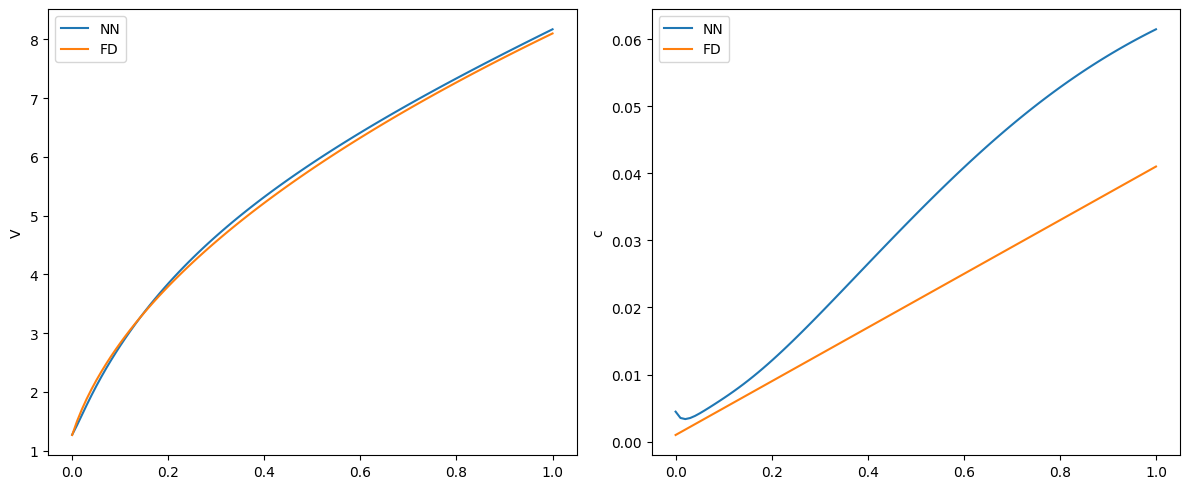

In [4]:
fd_res = np.load("models/fd_sol.npz")
a_fd = fd_res["a"]
v_fd = torch.tensor(fd_res["V"], dtype=torch.float32, device=ode1.device).reshape(-1, 1)
c_fd = torch.tensor(fd_res["c"], dtype=torch.float32, device=ode1.device).reshape(-1, 1)
SV = torch.tensor(a_fd, dtype=torch.float32, device=ode1.device).reshape((-1, 1))
for i, sv_name in enumerate(ode1.state_variables):
    ode1.variable_val_dict[sv_name] = SV[:, i:i+1]
ode1.update_variables(SV)
mse_v = torch.mean(torch.square((ode1.variable_val_dict["V"] - v_fd)))
mse_c = torch.mean(torch.square((ode1.variable_val_dict["c"] - c_fd)))
linf_norm_v = torch.norm(ode1.variable_val_dict["V"] - v_fd, p=torch.inf)
linf_norm_c = torch.norm(ode1.variable_val_dict["c"] - c_fd, p=torch.inf)
print(f"V: MSE={mse_v}, Linf={linf_norm_v}")
print(f"c: MSE={mse_c}, Linf={linf_norm_c}")
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(a_fd, ode1.variable_val_dict["V"].detach().cpu().numpy(), label="NN")
ax[0].plot(a_fd, v_fd.detach().cpu().numpy(), label="FD")
ax[0].set_ylabel("V")
ax[0].legend()

ax[1].plot(a_fd, ode1.variable_val_dict["c"].detach().cpu().numpy(), label="NN")
ax[1].plot(a_fd, c_fd.detach().cpu().numpy(), label="FD")
ax[1].set_ylabel("c")
ax[1].legend()
plt.tight_layout()
plt.show()